# Package Installation and Imports

In [ ]:
# Will need to restart the session on Colab
!pip install evidential-deep-learning
!pip install tensorflow==2.15.0
!pip install keras==2.15.0
!pip install numpy==1.26.0

In [ ]:
# If uploading data as a zip file, unzip the folder
!unzip Unbiased_Dataset.zip

In [2]:
# Set random seed before imports

seed_value = 993

import random
random.seed(seed_value)

In [3]:
import tensorflow as tf
import numpy as np
import evidential_deep_learning as edl
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from random import randint
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import keras
from keras import optimizers
from keras import layers
import numpy.linalg as la
from sklearn.decomposition import PCA
from sklearn.metrics import root_mean_squared_error
import joblib

# Dimer Featurization

Featurize each dimer by computing the distance matrix between the heavy atoms on the OSC and dopant. Each entry is defined as the inverse distance between the indexed atoms.

This block should take 1-2 minutes to run on Google Colab CPU.

In [4]:
# Number of atoms per dimer
no_atom = 47

# Number of dimers
no_pairs = 59000

path_to_files = "./Unbiased_Dataset/"
filename = "P3HT_F4TCNQ_"

feat_vecs = []

for pair in range(no_pairs):

  # Prepare empty arrays to store the atomic coordinates and atom identities
  atom_coords = np.full((no_atom,3),0.0,dtype=float)
  elements = np.full(no_atom,'a',dtype=str)

  # Construct the path to the xyz file
  filename_xyz = filename + "%06d.xyz" %(pair)
  xyz_path = path_to_files + filename_xyz

  # Read in the atomic coordinates and atom identities
  with open(xyz_path) as f:
    f_lines = f.readlines()
    for atom in range(no_atom):
      line = f_lines[atom+2]
      split = line.split()
      elements[atom] = split[0]
      atom_coords[atom,0] = float(split[1])
      atom_coords[atom,1] = float(split[2])
      atom_coords[atom,2] = float(split[3])
  f.close()

  # Delete all non-heavy atoms from the arrays
  atom_coords_new = np.delete(atom_coords,
   [0,6,8,9,11,12,14,15,17,18,20,21,23,24,25,26],axis=0)
  elements_new = np.delete(elements,
   [0,6,8,9,11,12,14,15,17,18,20,21,23,24,25,26])

  # Compute the distance matrix among the remaining heavy atoms
  dist_matrix = np.zeros((11,20))
  for monomer_atom in range(11):
    for dopant_atom in range(20):
      dist_matrix[monomer_atom,dopant_atom] = 1/(la.norm(
          (atom_coords_new[monomer_atom,:] - atom_coords_new[11+dopant_atom,:])))

  # Flatten the distance matrix into a 220-dimensional feature vector
  feat_vec = dist_matrix.flatten()

  feat_vecs.append(feat_vec)

feat_vecs = np.array(feat_vecs)

np.save('feat_vecs',feat_vecs)

# Preparation of Dataset

In [5]:
# Load in array with ground truth electronic coupling values in eV for each dimer
dimer_couplings = np.load('./Unbiased_Dataset/nonw_feats_couplings_59.npy')

# Load in the featurized vectors for each dimer
# 220-dim feature vector arising from 11x20 flattened distance matrix between the heavy atoms for each dimer
dimer_feat_vecs = np.load('feat_vecs.npy')

In [6]:
# Perform train-test-split on the data: 80/10/10 training/validation/test

# Split the data into 80% total training set
random_state=666
x_train_total, x_val_test, y_train_total, y_val_test = train_test_split(dimer_feat_vecs,dimer_couplings,test_size=0.2,random_state=random_state)

# Split the remaining 20% data into validation and test sets
random_state = 555
x_val, x_test, y_val, y_test = train_test_split(x_val_test,y_val_test,test_size=0.5,random_state=random_state)

# Create an initial 10% training set from the total training data to start the active learning
random_state = 444
x_pool, x_train, y_pool, y_train = train_test_split(x_train_total,y_train_total,test_size=0.1,random_state=random_state)

In [7]:
# Perform PCA on the featurized vectors to reduce dimensionality of data
# Take the first 15 principal components as input to the neural network

# Fit standard scaling to total training set
scaler = StandardScaler()
scaled_x_train_total = scaler.fit_transform(x_train_total)

# Apply to the data
scaled_x_train = scaler.transform(x_train)
scaled_x_pool = scaler.transform(x_pool)
scaled_x_val = scaler.transform(x_val)
scaled_x_test = scaler.transform(x_test)

# Save the fit scaler object
joblib.dump(scaler, 'scaler.gz')

# Fit PCA object to total training set
pca = PCA(n_components = 15)
pca_x_train_total = pca.fit_transform(scaled_x_train_total)

# Apply to the data
pca_x_train = pca.transform(scaled_x_train)
pca_x_pool = pca.transform(scaled_x_pool)
pca_x_val = pca.transform(scaled_x_val)
pca_x_test = pca.transform(scaled_x_test)

# Save the fit PCA object
joblib.dump(pca, 'pca.gz')

['pca.gz']

In [8]:
# Save the dataset as an npz file
np.savez('dataset.npz',
         x_train=pca_x_train,
         y_train=y_train,
         x_test=pca_x_test,
         y_test=y_test,
         x_pool=pca_x_pool,
         y_pool=y_pool,
         x_val=pca_x_val,
         y_val=y_val,
         x_train_total=pca_x_train_total,
         y_train_total=y_train_total)

# Perform the Active Learning

In [9]:
##### Active learning parameters #####

# Compute total training set size
dataset = np.load('dataset.npz')
y_train = dataset['y_train']
y_pool = dataset['y_pool']
total_training_size = len(y_train) + len(y_pool)

# Number of active learning cycles
n_iterations = 4

# Sample 10% of total training data at each iteration
n_queries = int(total_training_size * 0.1)

##### Helper functions #####

def EvidentialRegressionLoss(true, pred):
  # Coeff is the evidential regularization hyperparameter
  return edl.losses.EvidentialRegression(true, pred, coeff=0.8)

def evidential_uncertainty(y_pred):
  # Collect parameters
  v = y_pred[:, 1]
  alpha = y_pred[:, 2]
  beta = y_pred[:, 3]

  # Compute uncertainty
  unc = beta / (v * (alpha - 1))

  return unc

def random_search(y_pred):
    rand_indices = []

    for i in range(n_queries):
      value = randint(0,len(y_pred) - 1)
      rand_indices.append(value)

    return rand_indices

def create_model():

  model = keras.Sequential()
  model.add(keras.Input(shape=(15,)))
  model.add(layers.Dense(128, activation="relu"))
  model.add(layers.Dense(64, activation="relu"))
  model.add(layers.Dense(32, activation="relu"))
  model.add(edl.layers.DenseNormalGamma(1))

  return model

##### Main active learning code #####

def main():

    # Track metrics for model performance
    r2 = []
    rmse = []

    # Track the size of the training set at each cycle
    training_set_sizes = []

    # Set the random seed for neural network initialization
    keras.utils.set_random_seed(seed_value)

    # Load in the data
    dataset = np.load('dataset.npz')
    x_train = dataset['x_train']
    y_train = dataset['y_train']
    x_test = dataset['x_test']
    y_test = dataset['y_test']
    x_pool = dataset['x_pool']
    y_pool = dataset['y_pool']

    # Create model
    model = create_model()

    # Compile and fit the model
    model.compile(
      optimizer='adam',
      loss=EvidentialRegressionLoss
    )

    history = model.fit(x_train, y_train, epochs = 150, batch_size = 64, verbose=0)

    # Predict using model
    y_pred_test = model.predict(x_test)
    y_pred_pool = model.predict(x_pool)

    # The gamma output is the neural network prediction
    y_pred_pool_gamma = y_pred_pool[:,0]
    y_pred_test_gamma = y_pred_test[:,0]

    # Print the percentage of training data in the current training set
    print("-----[Initial Training]-----")
    print("Training set: " + str((len(y_train) / total_training_size) * 100) + "%")

    # Get initial R2 and RMSE values
    r2.append(r2_score(y_test, y_pred_test_gamma))
    print("R2: " + str(r2_score(y_test, y_pred_test_gamma)))
    rmse.append(root_mean_squared_error(y_test, y_pred_test_gamma))
    print("RMSE: " + str(root_mean_squared_error(y_test, y_pred_test_gamma)))

    # Track the current size of the training set
    training_set_sizes.append((len(x_train) / total_training_size) * 100)

    # Active learning loop
    for iteration in range(n_iterations):

        # Sampling with evidential uncertainty
        uncertainty = evidential_uncertainty(y_pred_pool)
        unc_sorted_indices = np.argsort(uncertainty)
        query_indices = unc_sorted_indices[-n_queries:]

        # Sampling with random search
        #query_indices = random_search(y_pred_pool_gamma)

        # Add n highest uncertainty data points to training set
        for i in range(len(query_indices)):
          x_train = np.append(x_train, np.reshape(x_pool[query_indices[i]], (1,15)), axis=0)
          y_train = np.append(y_train, y_pool[query_indices[i]])

        # Delete n highest uncertainty data points from pool set
        x_pool = np.delete(x_pool, query_indices, axis=0)
        y_pool = np.delete(y_pool, query_indices)

        # Recreate the model
        model = create_model()

        # Compile and fit the model on new training set
        model.compile(
          optimizer='adam',
          loss=EvidentialRegressionLoss
        )

        history = model.fit(x_train, y_train, epochs = 150, batch_size = 64, verbose=0)

        # Predict using model
        y_pred_test = model.predict(x_test)
        y_pred_test_gamma = y_pred_test[:,0]

        # Print the percentage of total training data in the current training set
        print(f"-----[Cycle {iteration + 1}]-----")
        print("Training set: " + str((len(y_train) / total_training_size) * 100) + "%")

        # Get the R2 and RMSE values
        r2.append(r2_score(y_test, y_pred_test_gamma))
        print("R2: " + str(r2_score(y_test, y_pred_test_gamma)))
        rmse.append(root_mean_squared_error(y_test, y_pred_test_gamma))
        print("RMSE: " + str(root_mean_squared_error(y_test, y_pred_test_gamma)))

        # Track the size of the training set
        training_set_sizes.append((len(x_train) / total_training_size) * 100)

        # Predict on data pool for uncertainty sampling except on final cycle
        if (iteration != (n_iterations - 1)):
          y_pred_pool = model.predict(x_pool)
          y_pred_pool_gamma = y_pred_pool[:,0]

    # Save list of metrics at each active learning iteration
    np.save('total_r2', r2)
    np.save('total_rmse', rmse)

    # Save training set size at each active learning iteration
    np.save('training_set_sizes',training_set_sizes)

In [10]:
main()

1328/1328 [==============================] - 2s 2ms/step
-----[Initial Training]-----
Training set: 10.0%
R2: 0.6314949968975223
RMSE: 0.016241322903261097
185/185 [==============================] - 0s 1ms/step
-----[Cycle 1]-----
Training set: 20.0%
R2: 0.8226663628149056
RMSE: 0.011266662047082166
185/185 [==============================] - 0s 1ms/step
-----[Cycle 2]-----
Training set: 30.0%
R2: 0.8438877046617708
RMSE: 0.010571053267939237
185/185 [==============================] - 0s 1ms/step
-----[Cycle 3]-----
Training set: 40.0%
R2: 0.8409224845755192
RMSE: 0.010670975094027002
185/185 [==============================] - 0s 1ms/step
-----[Cycle 4]-----
Training set: 50.0%
R2: 0.8503007340708002
RMSE: 0.010351649102956002


# Plot Active Learning Metrics

In [11]:
def plot_rmse():

    total_rmse = np.load("total_rmse.npy")

    training_set_sizes = np.load("training_set_sizes.npy")

    plt.plot(training_set_sizes, total_rmse*1000, 'o-', markersize=5)

    plt.xlabel("Fraction of Training Data (%)",fontsize=20)
    plt.ylabel("RMSE (meV)",fontsize=20)
    plt.xticks([10.0, 20.0, 30.0, 40.0, 50.0],fontsize=18)
    plt.yticks(fontsize=18)

In [12]:
def plot_r2():

    total_r2 = np.load("total_r2.npy")

    training_set_sizes = np.load("training_set_sizes.npy")

    plt.plot(training_set_sizes, total_r2, 'o-', markersize=5)

    plt.xlabel("Fraction of Training Data (%)",fontsize=20)
    plt.ylabel("$R^2$",fontsize=20,labelpad=0)
    plt.xticks([10.0, 20.0, 30.0, 40.0, 50.0],fontsize=18)
    plt.yticks(fontsize=18)

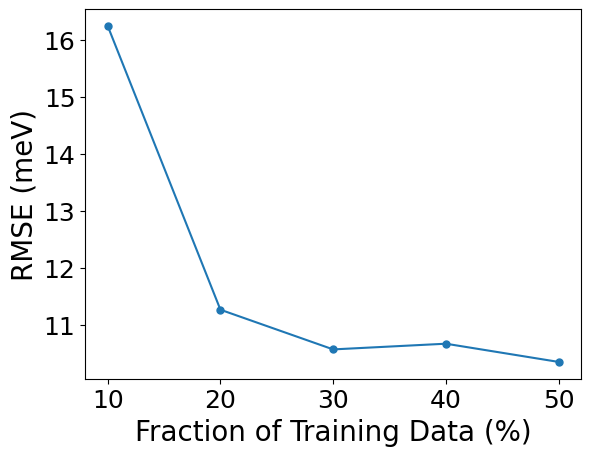

In [13]:
plot_rmse()

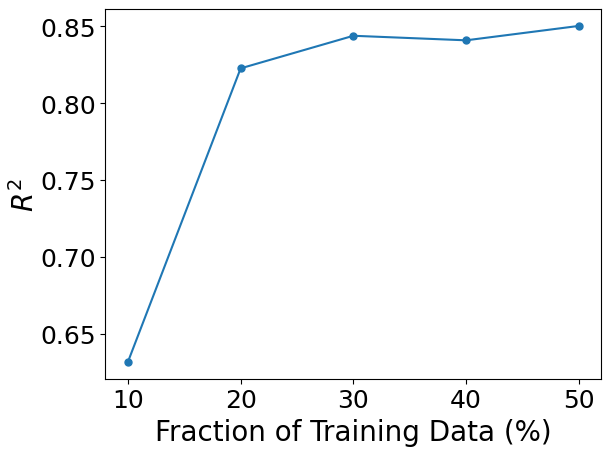

In [14]:
plot_r2()